In [2]:
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.utils import evaluate_print
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import scipy as sp
from suod.models.base import SUOD
from suod.utils.utility import get_estimators_small
from combo.models.score_comb import majority_vote, maximization, average
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [2]:
# load files
mat_file_list = [
    'cardio.mat',
    # 'satellite.mat',
    # 'satimage-2.mat',
    # 'mnist.mat',
]

mat_file = mat_file_list[0]
mat_file_name = mat_file.replace('.mat', '')
print("\n... Processing", mat_file_name, '...')
mat = sp.io.loadmat(os.path.join('', 'data', mat_file))

X = mat['X']
y = mat['y']

# standardize data to be digestible for most algorithms
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

contamination = y.sum() / len(y)
base_estimators = get_estimators_small(contamination)

model = SUOD(base_estimators=base_estimators, n_jobs=6, bps_flag=True,
                 contamination=contamination, approx_flag_global=True)

model.fit(X_train)  # fit all models with X
model.approximate(X_train)  # conduct model approximation if it is enabled
predicted_labels = model.predict(X_test)  # predict labels
predicted_scores = model.decision_function(X_test)  # predict scores
predicted_probs = model.predict_proba(X_test)  # predict scores

###########################################################################
# compared with other approaches
evaluate_print('majority vote', y_test, majority_vote(predicted_labels))
evaluate_print('average', y_test, average(predicted_scores))
evaluate_print('maximization', y_test, maximization(predicted_scores))

clf = LOF()
clf.fit(X_train)
evaluate_print('LOF', y_test, clf.decision_function(X_test))

clf = IForest()
clf.fit(X_train)
evaluate_print('IForest', y_test, clf.decision_function(X_test))



... Processing cardio ...
RandomForestRegressor()



[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.1s remaining:    2.3s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    8.7s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.3s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:   10.9s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    1.5s remaining:    3.2s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    6.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.0s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    5.8s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[Parallel(n_jobs=6)]: Done   2 out of   6 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    5.6s finished


majority vote ROC:0.683, precision @ rank n:0.5357
average ROC:0.9581, precision @ rank n:0.6216
maximization ROC:0.9581, precision @ rank n:0.6216
LOF ROC:0.6365, precision @ rank n:0.2027
IForest ROC:0.9244, precision @ rank n:0.5135


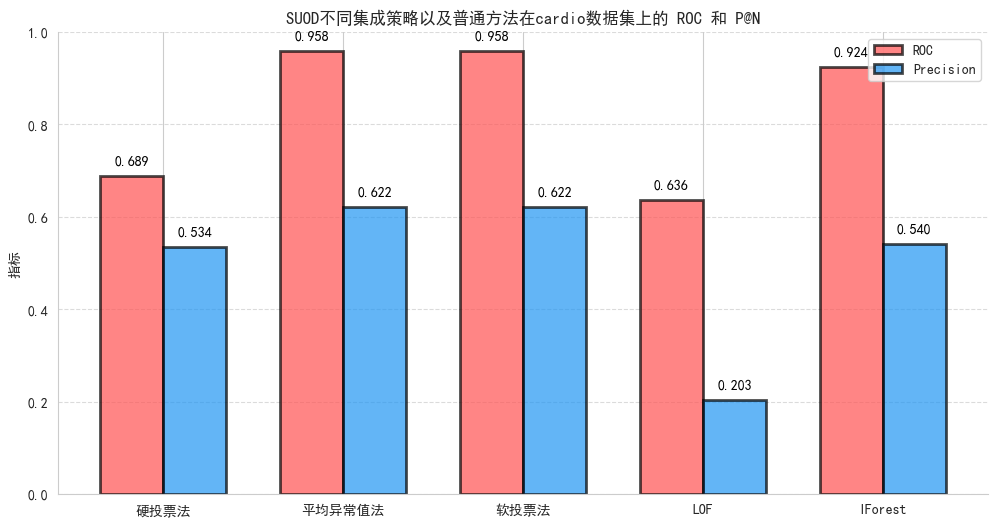

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
methods = ['硬投票法', '平均异常值法', '软投票法', 'LOF', 'IForest']
roc_values = [0.689, 0.9581, 0.9581, 0.6365, 0.9237]
precision_values = [0.5345, 0.6216, 0.6216, 0.2027, 0.5405]

# Bar width
bar_width = 0.35
index = np.arange(len(methods))

# Colors
roc_color = '#FF5252'  # Red
precision_color = '#2196F3'  # Blue

# Plotting ROC and Precision values
plt.figure(figsize=(12, 6))

roc_bars = plt.bar(index, roc_values, bar_width, color=roc_color, alpha=0.7, label='ROC', edgecolor='black', linewidth=2)
precision_bars = plt.bar(index + bar_width, precision_values, bar_width, color=precision_color, alpha=0.7, label='Precision', edgecolor='black', linewidth=2)

plt.ylim(0, 1)
plt.ylabel('指标')
plt.title('SUOD不同集成策略以及普通方法在cardio数据集上的 ROC 和 P@N')
plt.xticks(index + bar_width / 2, methods)
plt.legend(loc='upper right')

# Adding values as text labels on the bars
for i, (roc_val, precision_val) in enumerate(zip(roc_values, precision_values)):
    plt.text(i, roc_val + 0.02, f'{roc_val:.3f}', ha='center', va='bottom', color='black')
    plt.text(i + bar_width, precision_val + 0.02, f'{precision_val:.3f}', ha='center', va='bottom', color='black')

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Removing top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.show()
